# set up environment and read in dataset

In [33]:
library(Seurat)
library(dplyr)

# Load the PBMC dataset
datadir <- "/data/clintko/data_pbmc"
pbmc.data <- Read10X(data.dir = file.path(datadir, "pbmc3k_filtered_gene_bc_matrices/hg19/"))

# Memory used by sparse matrix in seurat object

In [34]:
# Examine the memory savings between regular and sparse matrices
dense.size <- object.size(x = as.matrix(x = pbmc.data))
print(dense.size)

sparse.size <- object.size(x = pbmc.data)
print(sparse.size)

cat("Ratio:", dense.size/sparse.size)

709264728 bytes
38715120 bytes
Ratio: 18.3201

# Initialization

In [35]:
# Initialize the Seurat object with the raw (non-normalized data).  Keep all
# genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at
# least 200 detected genes
pbmc <- CreateSeuratObject(
    raw.data = pbmc.data, 
    min.cells = 3, 
    min.genes = 200, 
    project = "10X_PBMC")

# Quality Control

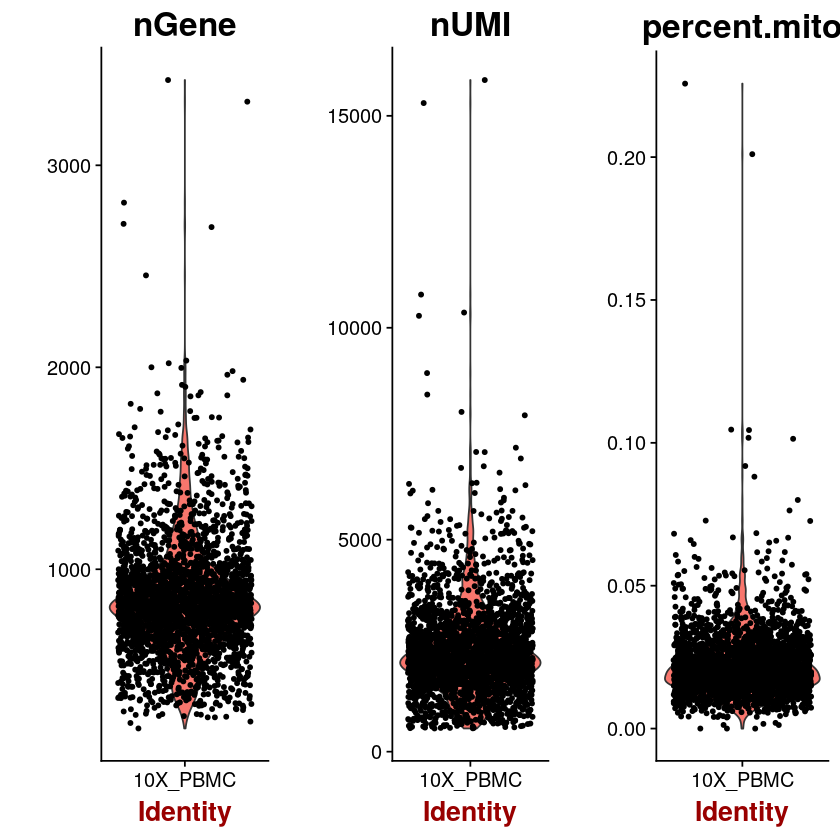

In [36]:
# The number of genes and UMIs (nGene and nUMI) are automatically calculated
# for every object by Seurat.  For non-UMI data, nUMI represents the sum of
# the non-normalized values within a cell We calculate the percentage of
# mitochondrial genes here and store it in percent.mito using AddMetaData.
# We use object@raw.data since this represents non-transformed and
# non-log-normalized counts The % of UMI mapping to MT-genes is a common
# scRNA-seq QC metric.
mito.genes <- grep(pattern = "^MT-", x = rownames(x = pbmc@data), value = TRUE)
percent.mito <- Matrix::colSums(pbmc@raw.data[mito.genes, ])/Matrix::colSums(pbmc@raw.data)

# AddMetaData adds columns to object@meta.data, and is a great place to
# stash QC stats
pbmc <- AddMetaData(object = pbmc, metadata = percent.mito, col.name = "percent.mito")
VlnPlot(object = pbmc, features.plot = c("nGene", "nUMI", "percent.mito"), nCol = 3)

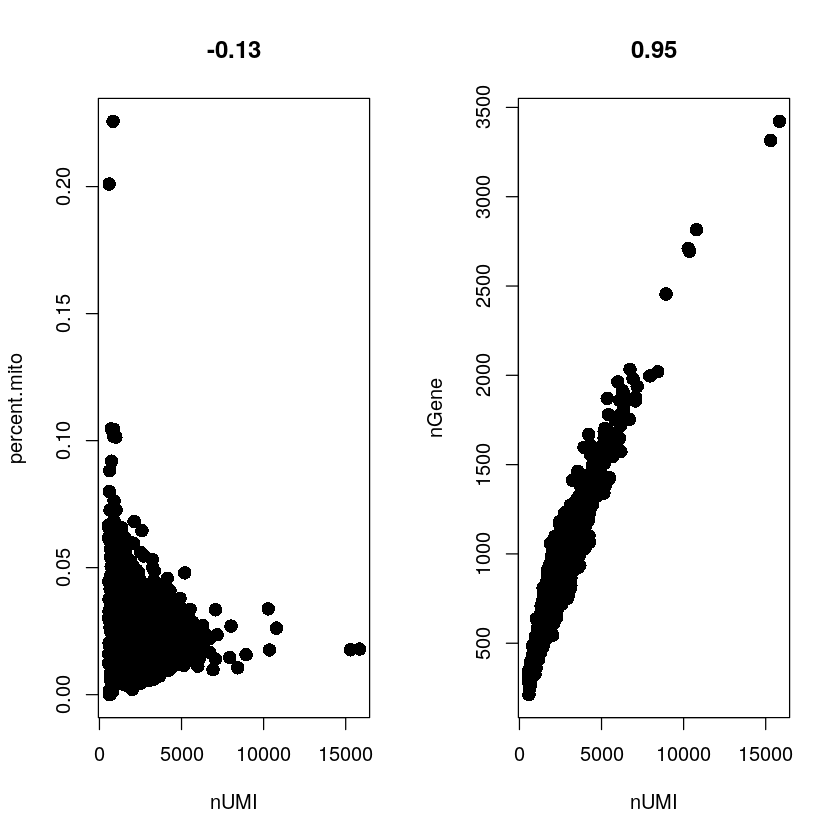

In [37]:
# GenePlot is typically used to visualize gene-gene relationships, but can
# be used for anything calculated by the object, i.e. columns in
# object@meta.data, PC scores etc.  Since there is a rare subset of cells
# with an outlier level of high mitochondrial percentage and also low UMI
# content, we filter these as well
par(mfrow = c(1, 2))
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "percent.mito")
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "nGene")

In [38]:
# We filter out cells that have unique gene counts over 2,500 or less than
# 200 Note that low.thresholds and high.thresholds are used to define a
# 'gate'.  -Inf and Inf should be used if you don't want a lower or upper
# threshold.
pbmc <- FilterCells(
    object = pbmc, 
    subset.names = c("nGene", "percent.mito"), 
    low.thresholds = c(200, -Inf), 
    high.thresholds = c(2500, 0.05))

# Normalizing the data

In [39]:
pbmc <- NormalizeData(
    object = pbmc, 
    normalization.method = "LogNormalize", 
    scale.factor = 10000)

# Detection of variable genes across the single cells

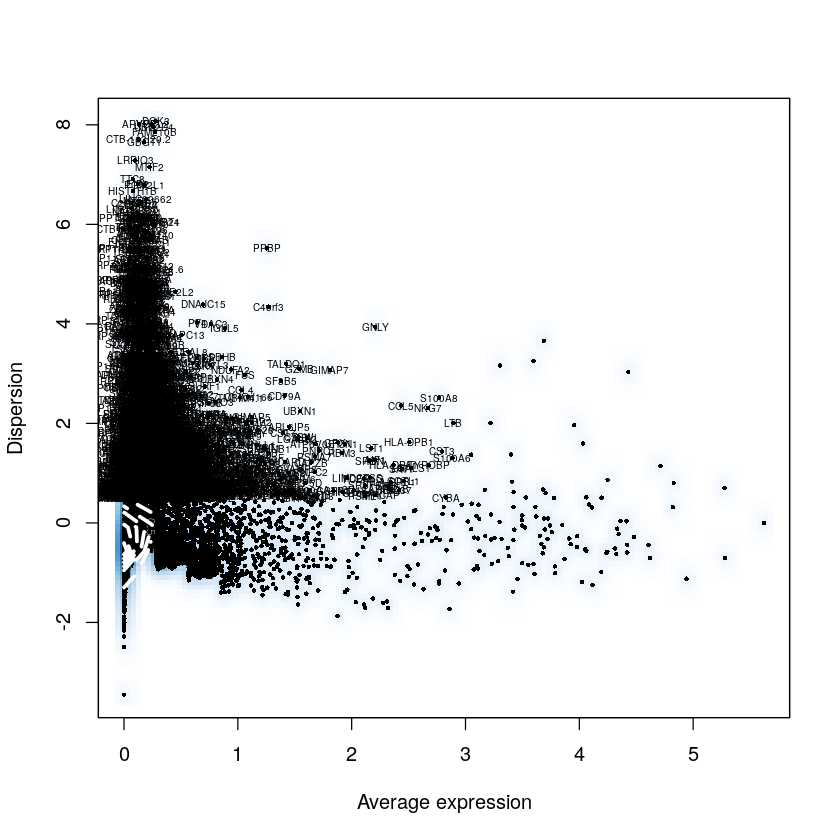

In [40]:
pbmc <- FindVariableGenes(
    object = pbmc, 
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    x.low.cutoff = 0.0125, 
    x.high.cutoff = 3, y.cutoff = 0.5)

In [41]:
length(x = pbmc@var.genes)

[1] 1838

# Scaling the data and removing unwanted sources of variation

In [14]:
pbmc <- ScaleData(object = pbmc, vars.to.regress = c("nUMI", "percent.mito"))

Regressing out: nUMI, percent.mito



Time Elapsed:  17.9954602718353 secs

Scaling data matrix


# Perform linear dimensional reduction

## Principle component analysis (PCA)

In [15]:
pbmc <- RunPCA(
    object = pbmc, 
    pc.genes = pbmc@var.genes, 
    do.print = TRUE, 
    pcs.print = 1:5, 
    genes.print = 5)

[1] "PC1"
[1] "CST3"   "TYROBP" "FCN1"   "LST1"   "AIF1"  
[1] ""
[1] "PTPRCAP" "IL32"    "LTB"     "CD2"     "CTSW"   
[1] ""
[1] ""
[1] "PC2"
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] ""
[1] ""
[1] "PC3"
[1] "PF4"   "PPBP"  "SDPR"  "SPARC" "GNG11"
[1] ""
[1] "CYBA"     "HLA-DPA1" "HLA-DPB1" "HLA-DRB1" "CD37"    
[1] ""
[1] ""
[1] "PC4"
[1] "IL32"   "GIMAP7" "AQP3"   "FYB"    "MAL"   
[1] ""
[1] "CD79A"    "HLA-DQA1" "CD79B"    "MS4A1"    "HLA-DQB1"
[1] ""
[1] ""
[1] "PC5"
[1] "FCGR3A"        "CTD-2006K23.1" "IFITM3"        "ABI3"         
[5] "CEBPB"        
[1] ""
[1] "FCER1A"  "LGALS2"  "MS4A6A"  "S100A8"  "CLEC10A"
[1] ""
[1] ""


Seurat provides several useful ways of visualizing both cells and genes that define the PCA, including

- PrintPCA
- VizPCA
- PCAPlot
- PCHeatmap

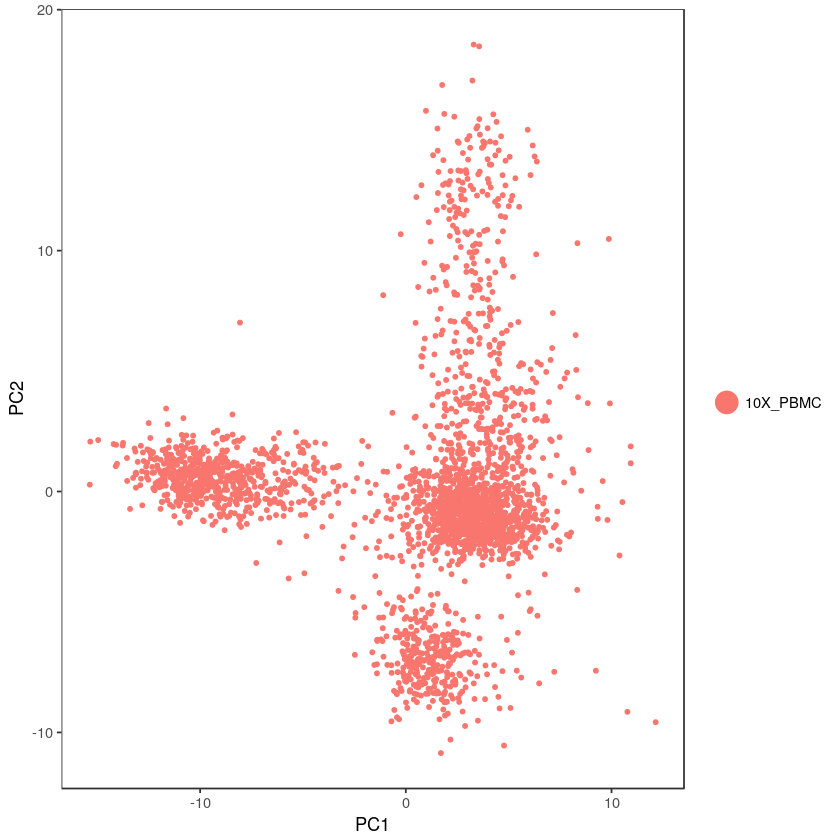

In [16]:
PCAPlot(object = pbmc, dim.1 = 1, dim.2 = 2)

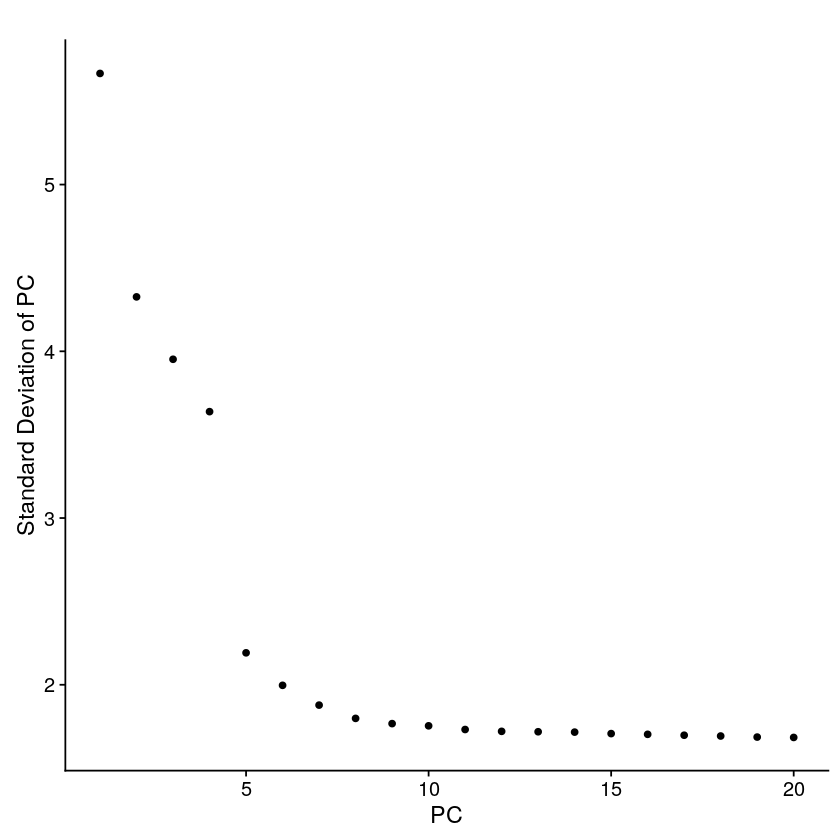

In [17]:
PCElbowPlot(object = pbmc)

# Cluster the cells

In [18]:
# save.SNN = T saves the SNN so that the clustering algorithm can be rerun
# using the same graph but with a different resolution value (see docs for
# full details)
pbmc <- FindClusters(
    object = pbmc, 
    reduction.type = "pca", 
    dims.use = 1:10, 
    resolution = 0.6, 
    print.output = 0, 
    save.SNN = TRUE)

In [19]:
PrintFindClustersParams(object = pbmc)

Parameters used in latest FindClusters calculation run on: 2018-06-27 14:03:41
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          prune.SNN
     pca                 30                0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10



# Run Non-linear dimensional reduction (tSNE)

In [20]:
pbmc <- RunTSNE(object = pbmc, dims.use = 1:10, do.fast = TRUE)

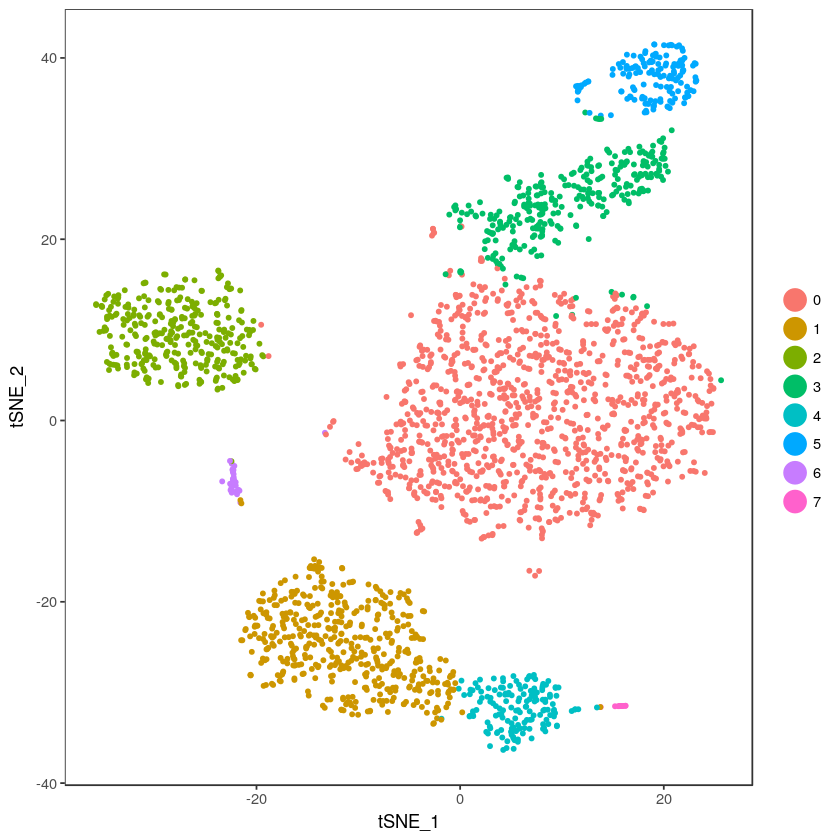

In [21]:
# note that you can set do.label=T to help label individual clusters
TSNEPlot(object = pbmc)

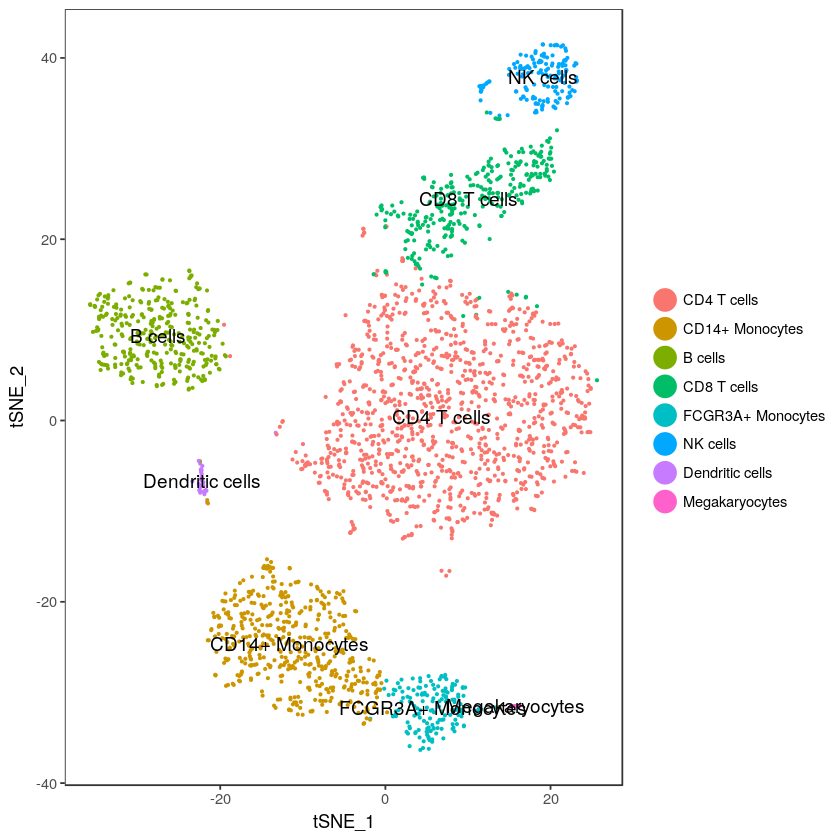

In [23]:
current.cluster.ids <- c(0, 1, 2, 3, 4, 5, 6, 7)
new.cluster.ids <- c("CD4 T cells", "CD14+ Monocytes", "B cells", "CD8 T cells", 
    "FCGR3A+ Monocytes", "NK cells", "Dendritic cells", "Megakaryocytes")
pbmc@ident <- plyr::mapvalues(x = pbmc@ident, from = current.cluster.ids, to = new.cluster.ids)
TSNEPlot(object = pbmc, do.label = TRUE, pt.size = 0.5)

In [26]:
pbmc@ident

AAACATACAACCAC    AAACATTGAGCTAC    AAACATTGATCAGC    AAACCGTGCTTCCG 
      CD4 T cells           B cells       CD4 T cells   CD14+ Monocytes 
   AAACCGTGTATGCG    AAACGCACTGGTAC    AAACGCTGACCAGT    AAACGCTGGTTCTT 
         NK cells       CD4 T cells       CD8 T cells       CD8 T cells 
   AAACGCTGTAGCCA    AAACGCTGTTTCTG    AAACTTGAAAAACG    AAACTTGATCCAGA 
      CD8 T cells FCGR3A+ Monocytes           B cells       CD4 T cells 
   AAAGAGACGAGATA    AAAGAGACGCGAGA    AAAGAGACGGACTT    AAAGAGACGGCATT 
      CD4 T cells   CD14+ Monocytes       CD8 T cells       CD4 T cells 
   AAAGCAGATATCGG    AAAGCCTGTATGCG    AAAGGCCTGTCTAG    AAAGTTTGATCACG 
  CD14+ Monocytes       CD4 T cells           B cells           B cells 
   AAAGTTTGGGGTGA    AAAGTTTGTAGAGA    AAAGTTTGTAGCGT    AAATCAACAATGCC 
          B cells       CD4 T cells   CD14+ Monocytes           B cells 
   AAATCAACACCAGT    AAATCAACCAGGAG    AAATCAACCCTATT    AAATCAACGGAAGC 
      CD4 T cells       CD4 T cells       CD4 T cells       CD4 T cells 
   AAATCAACTCGCAA    AAATCATGACCACA    AAATCCCTCCACAA    AAATCCCTGCTATG 
      CD4 T cells FCGR3A+ Monocytes       CD4 T cells           B cells 
   AAATGTTGAACGAA    AAATGTTGCCACAA    AAATGTTGTGGCAT    AAATTCGAAGGTTC 
  CD14+ Monocytes       CD4 T cells   CD14+ Monocytes       CD4 T cells 
   AAATTCGAATCACG    AAATTCGAGCTGAT    AAATTCGAGGAGTG    AAATTCGATTCTCA 
  CD14+ Monocytes FCGR3A+ Monocytes       CD4 T cells          NK cells 
   AAATTGACACGACT    AAATTGACTCGCTC    AACAAACTCATTTC    AACAAACTTTCGTT 
      CD8 T cells       CD8 T cells       CD4 T cells       CD4 T cells 
   AACAATACGACGAG    AACACGTGCAGAGG    AACACGTGGAAAGT    AACACGTGGAACCT 
      CD4 T cells       CD4 T cells       CD4 T cells   CD14+ Monocytes 
   AACACGTGGCTACA    AACACGTGTACGAC    AACAGCACAAGAGT    AACATTGATGGGAG 
      CD4 T cells FCGR3A+ Monocytes   CD14+ Monocytes FCGR3A+ Monocytes 
   AACCAGTGATACCG    AACCCAGATCGCTC    AACCGATGCTCCCA    AACCGATGGTCATG 
FCGR3A+ Monocytes       CD4 T cells       CD4 T cells           B cells 
   AACCGATGTTCTAC    AACCGCCTAGCGTT    AACCGCCTCTACGA    AACCTACTGTGAGG 
  CD14+ Monocytes       CD4 T cells   CD14+ Monocytes   CD14+ Monocytes 
   AACCTACTGTGTTG    AACCTTACGAGACG    AACCTTACGCGAGA    AACCTTACTAACGC 
      CD4 T cells       CD4 T cells          NK cells FCGR3A+ Monocytes 
   AACCTTTGGACGGA    AACCTTTGTACGCA    AACGCAACAAGTAG    AACGCATGACCCAA 
      CD4 T cells FCGR3A+ Monocytes       CD4 T cells       CD4 T cells 
   AACGCATGCCTTCG    AACGCATGTACTTC    AACGCCCTCGGGAA    AACGCCCTCGTACA 
      CD4 T cells       CD4 T cells       CD4 T cells          NK cells 
   AACGCCCTGGCATT    AACGTCGAGTATCG    AACGTGTGAAAGCA    AACGTGTGGCGGAA 
      CD4 T cells          NK cells       CD4 T cells           B cells 
   AACGTGTGTCCAAG    AACGTGTGTGCTTT    AACTACCTTAGAGA    AACTCACTCAAGCT 
      CD4 T cells       CD4 T cells       CD4 T cells   CD14+ Monocytes 
   AACTCACTTGGAGG    AACTCGGAAAGTGA    AACTCGGAAGGTCT    AACTCTTGCAGGAG 
  CD14+ Monocytes       CD8 T cells   CD14+ Monocytes       CD4 T cells 
   AACTGTCTCCCTTG    AACTTGCTACGCTA    AACTTGCTGGGACA    AAGAACGAGTGTTG 
  CD14+ Monocytes           B cells       CD4 T cells       CD4 T cells 
   AAGAAGACGTAGGG    AAGACAGAAGTCTG    AAGACAGAGGATCT    AAGACAGATTACCT 
          B cells           B cells       CD4 T cells   CD14+ Monocytes 
   AAGAGATGGGTAGG    AAGATGGAAAACAG    AAGATGGAGAACTC    AAGATGGAGATAAG 
          B cells           B cells   CD14+ Monocytes   CD14+ Monocytes 
   AAGATTACAACCTG    AAGATTACAGATCC    AAGATTACCCGTTC    AAGATTACCGCCTT 
      CD4 T cells   CD14+ Monocytes   CD14+ Monocytes   Dendritic cells 
   AAGATTACCTCAAG    AAGATTACTCCTCG    AAGCAAGAGCGAGA    AAGCAAGAGCTTAG 
         NK cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
   AAGCAAGAGGTGTT    AAGCACTGAGCAAA    AAGCACTGCATACG    AAGCACTGGTTCTT 
         NK cells           B cells       CD8 T cells           B cells 
   AAGCCAACGTGTTG    AAGCCATGAACTGC    AAGCCATGACACGT    AAGC

In [25]:
length(pbmc@ident)

[1] 2638

In [30]:
cell_labels <- data.frame(
    barcode = names(pbmc@ident), 
    label = pbmc@ident)
head(cell_labels)

,barcode,label
AAACATACAACCAC,AAACATACAACCAC,CD4 T cells
AAACATTGAGCTAC,AAACATTGAGCTAC,B cells
AAACATTGATCAGC,AAACATTGATCAGC,CD4 T cells
AAACCGTGCTTCCG,AAACCGTGCTTCCG,CD14+ Monocytes
AAACCGTGTATGCG,AAACCGTGTATGCG,NK cells
AAACGCACTGGTAC,AAACGCACTGGTAC,CD4 T cells


In [31]:
write.table(cell_labels, "pbmc3k_cell_labels.tsv", row.names = FALSE)